# CNN Compression 
### A very brief notebook with some of my results with pruning neural networks, and the lottery ticket hypothesis.

In [1]:
import altair as alt
import pandas as pd
import numpy as np
import src.eval 
from other.plots import compressed_models_results 
%load_ext autoreload
%autoreload 2

In [2]:
def line(df,x,y,title='Line'):
    return alt.Chart(df,width=300).mark_line(point=True).encode(
    x=alt.X('{}:O'.format(x),sort=alt.EncodingSortField(\
    x, order='descending')),y=alt.Y('{}:Q'.format(y),)).properties(title=title).interactive()

### The Lottery Ticket Hypothesis: Finding Sparse, Trainable Neural Networks. 
Jonathan Frankle and Michael Carbin, MIT CASIL. ICLR 2018.


#### Recent work suggests neural networks are over parameterized. Frankle states that "dense neural networks have sparse, trainable networks that are equally capable". Concretely;

Take two artificial neural networks: 
- $f(x:\theta)$, which achieves accuracy $a$ in $t$ iterations.
- $f(x:m \odot \theta)$, which achieves accuracy $a^{\prime}$ in $t^{\prime}$ iterations.
- With $m \in \{ 0,1 \}^{|\theta|}$

$\implies \space \exists m \space$ s.t $\space\space\space ||m||_{0} \ll |\theta|$, $\space\space\space a^{\prime} \geq a$, $\space\space\space t^{\prime} \leq t$

In [3]:
resnets_benign,resnets_adv,mobnets_benign,mobnets_adv = compressed_models_results()

### Let's observe this phenomenon with a few CNNs

### First ResNet. Has 21,273,600 weights. This network is over-parameterized and can be pruned, but is very weak to slight perturbations. 

In [4]:
line(resnets_benign,'Compression Ratio','Accuracy',title='Resnets') | line(resnets_adv,'Compression Ratio','Accuracy',title='Resnets')

alt.HConcatChart(...)

### Now MobileNet. Has 2,279,368 weights. This network is trained on the same task and is not quite as over parameterized.

In [5]:
line(mobnets_benign,'Compression Ratio','Accuracy',title='Mobile Nets Accuracy') | line(mobnets_adv,'Compression Ratio','Accuracy',title='Mobilenets Against Weakest Adversary')

alt.HConcatChart(...)

### In the context of an orchestrator, a client comes in with (or without) a model. They have a use case in mind they know the security risks and performance needs for that use case (at least somewhat)

#### They may want to know one of two things:
1. On which hardware should I run such a model?
2. How can I optimize this model

#### Rumor has it the lottety ticket hypothesis does not stand when we add robustness to the recipe...
* A model adversarially trained and pruned from scratch converges to a saddle point in $\frac{1}{3}$ of the training iterations.
* That is, $\displaystyle\min_{\theta} \mathbb{E}_{x,y\sim \hat{\mathcal{D}}}\left[\max_{\delta \in \Delta} \mathcal{L}(\theta;x+\delta,y) \right]$ reaches a saddle point, or nash equilibrium early, and to a poor optima.
* Accuracy is stuck around 53% for benign data, and 28% for adversarial tests



#### My research from here on out will focus on:
1. Discovering what guarantees can be made for models whose use case is time, and security sensitive. 
2. Developping new tests for these models, including a more robust elbow test.
3. Making the algorithmic link between hardware and model

## Getting More Technical

In [6]:
from src.imaging import Model_Interpreter 
import torch
MI = Model_Interpreter()
MI.load_data(dataset='cifar10')
test_data = iter(MI.data)

Files already downloaded and verified


In [7]:
dense_resnet = MI.load_model('models/cifar10_models/resnet_dense1.pth','resnet')
pruned1_resnet = MI.load_model('models/cifar10_models/resnet_1pruned.pth','resnet')
pruned01_resnet = MI.load_model('models/cifar10_models/resnet_01pruned.pth','resnet')
dense_mobnet = MI.load_model('models/cifar10_models/mobilenet_dense.pth','mobilenet')
pruned1_mobnet = MI.load_model('models/cifar10_models/mobilenet_1pruned.pth','mobilenet')

# def time_n_examples(obj,mod,data,n):
#     t = 0
#     for _ in range(n):
#         tns,lab = next(data)
#         t += obj.predict(mod,tns,lab,ret='timed')
#     return t/n

# def remove_filters(mod):
#     ranks = {}
#     for k, v in mod.named_parameters():
#         if k.strip().split('.')[-1]=='weight':
#             ranks[k] = list(torch.nonzero(v).shape)[0]/torch.numel(v)
#     for k,v in ranks.items():
#         if v < 0.1:
#             if k[:5]=='layer':
#                 if 'shortcut' in k: continue
#                 indx = k[7]
#                 exec('mod.{}[{}].{}.data=torch.tensor([[0],[0],[0]])'.format(k[:6],indx,k[9:]))
#             else:
#                 exec('mod.{}.data=torch.tensor([0],[0],[0]])'.format(k))
                    
    
    #     if 'the_name_of_the_conv_you_want_to_zero_out' in key:
    #         value.data[0, 1, 22] = 0

In [8]:
# print(time_n_examples(MI,pruned01_resnet,test_data,100))
# print(time_n_examples(MI,dense_resnet,test_data,100))
# remove_filters(pruned01_resnet)
# print(time_n_examples(MI,pruned01_resnet,test_data,100))

In [9]:
# MI.load_data(dataset='cifar10',batch_size=128)

In [10]:
def cifar_resnet_flop(layer=110, prune_rate=1):
    '''
    :param layer: the layer of Resnet for Cifar, including 110, 56, 32, 20
    :param prune_rate: 1 means baseline
    :return: flop of the network
    '''
    flop = 0
    channel = [16, 32, 64]
    width = [32, 16, 8]

    stage = int(layer / 3)
    for index in range(0, layer, 1):
        if index == 0:  # first conv layer before block
            flop += channel[0] * width[0] * width[0] * 9 * 3 * prune_rate
        elif index in [1, 2]:  # first block of first stage
            flop += channel[0] * width[0] * width[0] * 9 * channel[0] * (prune_rate ** 2)
        elif 2 < index <= stage:  # other blocks of first stage
            if index % 2 != 0:
                # first layer of block, only output channal reduced, input channel remain the same
                flop += channel[0] * width[0] * width[0] * 9 * channel[0] * (prune_rate)
            elif index % 2 == 0:
                # second layer of block, both input and output channal reduced
                flop += channel[0] * width[0] * width[0] * 9 * channel[0] * (prune_rate ** 2)
        elif stage < index <= stage * 2:  # second stage
            if index % 2 != 0:
                flop += channel[1] * width[1] * width[1] * 9 * channel[1] * (prune_rate)
            elif index % 2 == 0:
                flop += channel[1] * width[1] * width[1] * 9 * channel[1] * (prune_rate ** 2)
        elif stage * 2 < index <= stage * 3:  # third stage
            if index % 2 != 0:
                flop += channel[2] * width[2] * width[2] * 9 * channel[2] * (prune_rate)
            elif index % 2 == 0:
                flop += channel[2] * width[2] * width[2] * 9 * channel[2] * (prune_rate ** 2)

    # offset for dimension change between blocks
    offset1 = channel[1] * width[1] * width[1] * 9 * channel[1] * prune_rate - channel[1] * width[1] * width[1] * 9 * \
              channel[0] * prune_rate
    offset2 = channel[2] * width[2] * width[2] * 9 * channel[2] * prune_rate - channel[2] * width[2] * width[2] * 9 * \
              channel[1] * prune_rate
    flop = flop - offset1 - offset2
    # print(flop)
    return flop


def cal_cifar_resnet_flop(layer, prune_rate):
    '''
    :param layer:  the layer of Resnet for Cifar, including 56, 32
    :param prune_rate: 1 means baseline
    :return:
    '''
    pruned_flop = cifar_resnet_flop(layer, prune_rate)
    baseline_flop = cifar_resnet_flop(layer, 1)

    print(
        "pruning rate of layer {:d} is {:.1f}, pruned FLOP is {:.0f}, "
        "baseline FLOP is {:.0f}, FLOP reduction rate is {:.4f}"
        .format(layer, prune_rate, pruned_flop, baseline_flop, 1 - pruned_flop / baseline_flop))



pruning_rate_list = [1, 0.1, 0.01]
for pruning_rate in pruning_rate_list:
    cal_cifar_resnet_flop(32, pruning_rate)

pruning rate of layer 32 is 1.0, pruned FLOP is 68861952, baseline FLOP is 68861952, FLOP reduction rate is 0.0000
pruning rate of layer 32 is 0.1, pruned FLOP is 3488809, baseline FLOP is 68861952, FLOP reduction rate is 0.9493
pruning rate of layer 32 is 0.0, pruned FLOP is 314907, baseline FLOP is 68861952, FLOP reduction rate is 0.9954


In [11]:
# 3488809/68861952
314907/68861952

0.004573018784015882

### Now a look at the distribution of weights in different networks

In [5]:
import src.weigh_prune as wp
import numpy as np
#Reloading earlier modules
from src.imaging import Model_Interpreter 
import torch
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
MI = Model_Interpreter()
MI.load_data(dataset='cifar10')
test_data = iter(MI.data)
# And now some models
dense_resnet = MI.load_model('models/cifar10_models/resnet_dense1.pth','resnet')
pruned1_resnet = MI.load_model('models/cifar10_models/resnet_1pruned.pth','resnet')
pruned01_resnet = MI.load_model('models/cifar10_models/resnet_01pruned.pth','resnet')
dense_mobnet = MI.load_model('models/cifar10_models/mobilenet_dense.pth','mobilenet')
pruned1_mobnet = MI.load_model('models/cifar10_models/mobilenet_1pruned.pth','mobilenet')
resnet_pgd = MI.load_model('models/cifar10_models/resnet_pgd.pth','resnet')

Files already downloaded and verified


In [71]:
from matplotlib import pyplot as plt

def hist_panel(*args,titles = [' ',' ',' ',' ']):
    fig, axes = plt.subplots(1, len(args), figsize=(16,6), sharex=True, sharey=True)
    colors = ['r','g','b','k','w']
    params = dict(alpha=0.3, bins=250,density=True,range=[-.15,.15])
    for i, (ax, cut) in enumerate(zip(axes, args)):
        if len(args[i])>1:
            for j in range(len(args[i])):
                if type(args[i][j])==str:
                    continue
                lab = args[i][j+1] if type(args[i][j+1])==str else ' '
                ax.hist(args[i][j], **params, label=lab, color=colors[j])
        else:
            ax.hist(args[i], **params, label=str(i), color=colors[1])
        ax.set_title(titles[i])
        ax.legend()
    plt.suptitle('Distribution of Weights in CNNs', y=1.05, size=16)

d = lambda x: wp.model_weight_distribution(x)
res1,res2,mob1,mob2 = d(dense_resnet),d(pruned1_resnet),d(dense_mobnet),d(pruned1_mobnet)

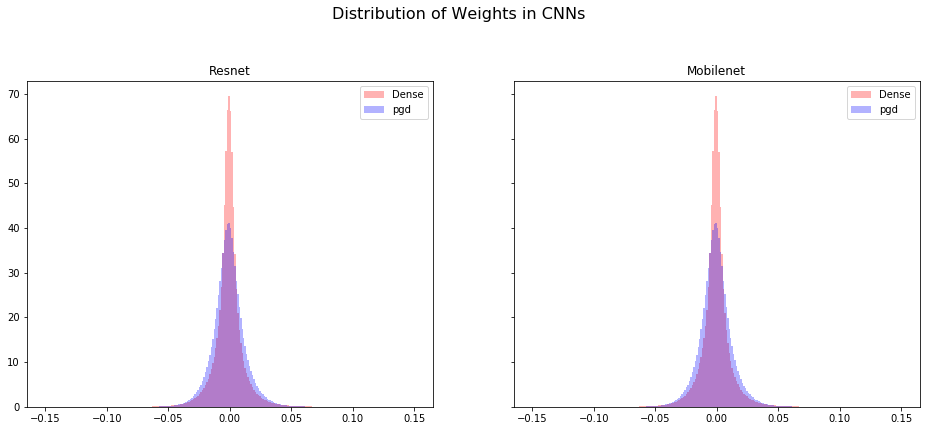

In [72]:
respgd = d(resnet_pgd)
# hist_panel([res1,'Dense',respgd,'pgd'],\
#            [mob1,'Dense',mob2,'10%'],\
#            titles = ['Resnet','Mobilenet']
#           )
hist_panel([res1,'Dense',respgd,'pgd'],
           [res1,'Dense',respgd,'pgd'],\
           titles = ['Resnet','Mobilenet']
          )